### DNA -> RNA transcription task using RNN, LSTM and GRU

Importing Libraries

In [2]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, LSTM, GRU, SimpleRNN, Dense
import matplotlib.pyplot as plt
import random

Setting up the sequence

In [3]:
# === Setup ===
dna_vocab = ['A', 'T', 'C', 'G']
rna_vocab = ['A', 'U', 'C', 'G']
transcription_map = {'A': 'U', 'T': 'A', 'C': 'G', 'G': 'C'}

dna_to_idx = {ch: i for i, ch in enumerate(dna_vocab)}
rna_to_idx = {ch: i for i, ch in enumerate(rna_vocab)}
idx_to_rna = {i: ch for ch, i in rna_to_idx.items()}
vocab_size = len(dna_vocab)



Generating DNA and RNA pairs

In [4]:
def generate_dna_rna_pairs(n_samples=1000, seq_len=10):
    X, y = [], []
    for _ in range(n_samples):
        dna_seq = [random.choice(dna_vocab) for _ in range(seq_len)]
        rna_seq = [transcription_map[ch] for ch in dna_seq]
        X.append([dna_to_idx[ch] for ch in dna_seq])
        y.append([rna_to_idx[ch] for ch in rna_seq])
    return np.array(X), np.array(y)


Building the model

In [5]:
def build_and_train_seq2seq_model(cell_type, X_train, y_train, X_test, y_test, seq_len, vocab_size, epochs=20):
    print(f"\n Training with {cell_type}...")

    # === Model ===
    inputs = Input(shape=(seq_len,))
    x = Embedding(input_dim=vocab_size, output_dim=8)(inputs)

    if cell_type == 'RNN':
        x = SimpleRNN(64, return_sequences=True)(x)
    elif cell_type == 'LSTM':
        x = LSTM(64, return_sequences=True)(x)
    elif cell_type == 'GRU':
        x = GRU(64, return_sequences=True)(x)
    else:
        raise ValueError("Unsupported cell type.")

    outputs = Dense(vocab_size, activation='softmax')(x)
    model = Model(inputs, outputs)
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    # === Train ===
    history = model.fit(
        X_train, y_train[..., np.newaxis],
        validation_data=(X_test, y_test[..., np.newaxis]),
        epochs=epochs, batch_size=32, verbose=0
    )

    # === Evaluate ===
    loss, acc = model.evaluate(X_test, y_test[..., np.newaxis], verbose=0)
    print(f"{cell_type} Test Accuracy: {acc:.4f}")

    return model, history, acc


Plotting the curves


In [6]:
def plot_training_curves(history, title_prefix="Model"):
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train', color='blue')
    plt.plot(history.history['val_accuracy'], label='Validation', color='orange')
    plt.title(f"{title_prefix} Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.grid(True)
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train', color='blue')
    plt.plot(history.history['val_loss'], label='Validation', color='orange')
    plt.title(f"{title_prefix} Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    plt.show()


Predicting the transcribed RNA

In [7]:
def show_prediction(model, X_sample, y_true):
    pred = model.predict(X_sample[np.newaxis, :], verbose=0)
    pred_seq = np.argmax(pred[0], axis=-1)
    dna_seq = ''.join([dna_vocab[i] for i in X_sample])
    actual_rna = ''.join([idx_to_rna[i] for i in y_true])
    predicted_rna = ''.join([idx_to_rna[i] for i in pred_seq])
    
    print("DNA Input     :", dna_seq)
    print("True RNA      :", actual_rna)
    print("Predicted RNA :", predicted_rna)



 Training with RNN...
RNN Test Accuracy: 1.0000


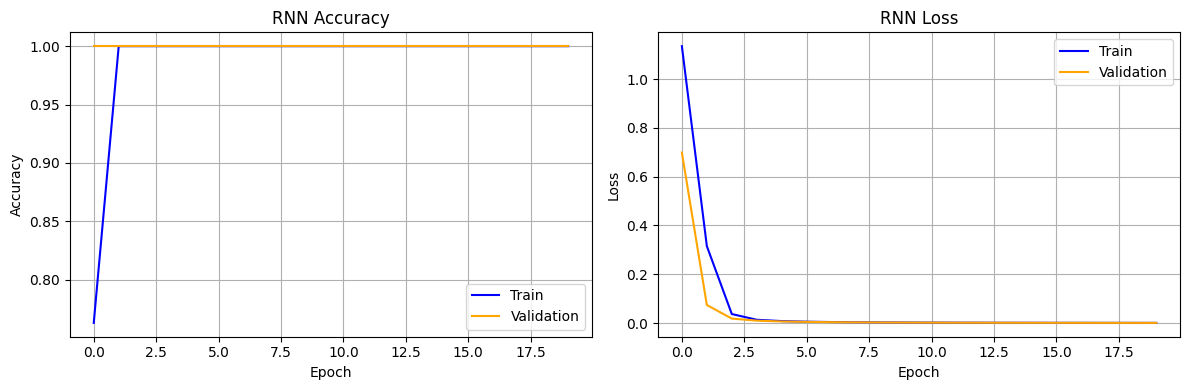

Final Test Accuracy for RNN: 1.0000
Sample prediction:
DNA Input     : CTGAGAATCACGTCGAGGCCTAGTAATACACCGTCCGTGGAATAATGCGCGCTGCGTGACTATACCCCTA
True RNA      : GACUCUUAGUGCAGCUCCGGAUCAUUAUGUGGCAGGCACCUUAUUACGCGCGACGCACUGAUAUGGGGAU
Predicted RNA : GACUCUUAGUGCAGCUCCGGAUCAUUAUGUGGCAGGCACCUUAUUACGCGCGACGCACUGAUAUGGGGAU
--------------------------------------------------

 Training with LSTM...
LSTM Test Accuracy: 1.0000


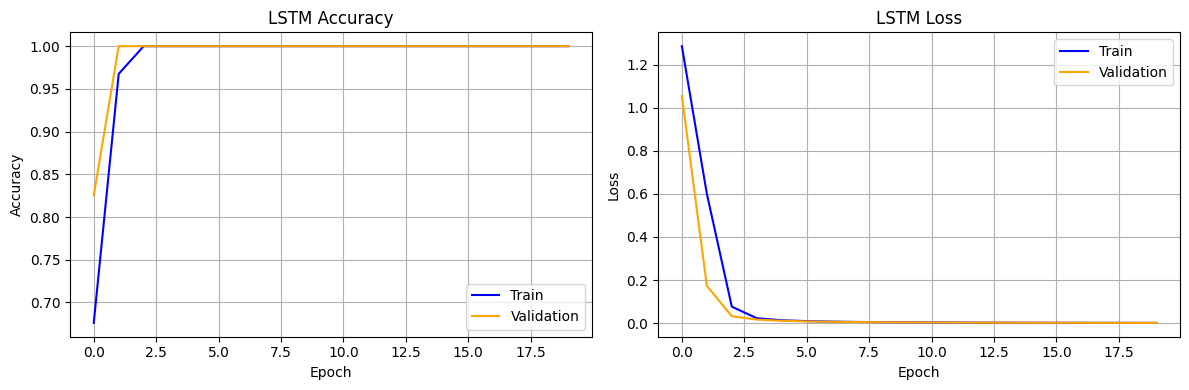

Final Test Accuracy for LSTM: 1.0000
Sample prediction:
DNA Input     : CTGAGAATCACGTCGAGGCCTAGTAATACACCGTCCGTGGAATAATGCGCGCTGCGTGACTATACCCCTA
True RNA      : GACUCUUAGUGCAGCUCCGGAUCAUUAUGUGGCAGGCACCUUAUUACGCGCGACGCACUGAUAUGGGGAU
Predicted RNA : GACUCUUAGUGCAGCUCCGGAUCAUUAUGUGGCAGGCACCUUAUUACGCGCGACGCACUGAUAUGGGGAU
--------------------------------------------------

 Training with GRU...
GRU Test Accuracy: 1.0000


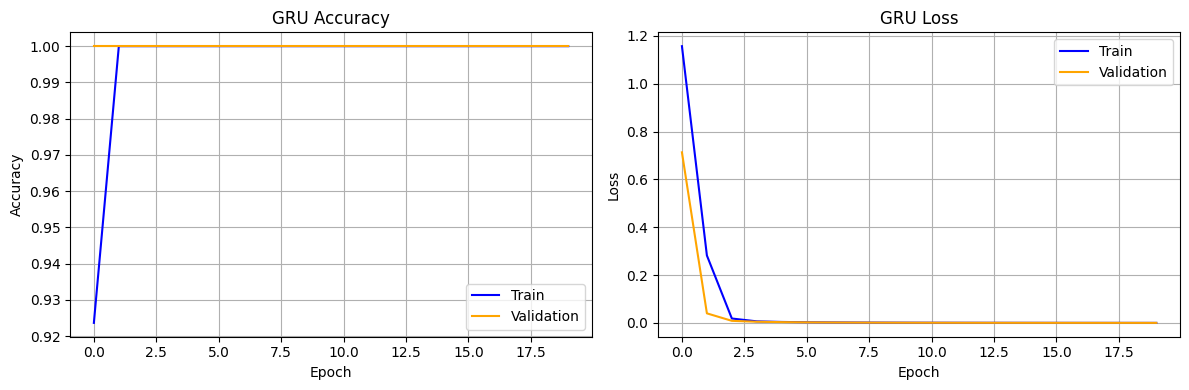

Final Test Accuracy for GRU: 1.0000
Sample prediction:
DNA Input     : CTGAGAATCACGTCGAGGCCTAGTAATACACCGTCCGTGGAATAATGCGCGCTGCGTGACTATACCCCTA
True RNA      : GACUCUUAGUGCAGCUCCGGAUCAUUAUGUGGCAGGCACCUUAUUACGCGCGACGCACUGAUAUGGGGAU
Predicted RNA : GACUCUUAGUGCAGCUCCGGAUCAUUAUGUGGCAGGCACCUUAUUACGCGCGACGCACUGAUAUGGGGAU
--------------------------------------------------


In [8]:
SEQ_LEN = 70
X_train, y_train = generate_dna_rna_pairs(1000, SEQ_LEN)
X_test, y_test = generate_dna_rna_pairs(200, SEQ_LEN)

for cell in ['RNN', 'LSTM', 'GRU']:
    model, history, acc = build_and_train_seq2seq_model(cell, X_train, y_train, X_test, y_test, SEQ_LEN, vocab_size)
    plot_training_curves(history, title_prefix=cell)
    print(f"Final Test Accuracy for {cell}: {acc:.4f}")
    print("Sample prediction:")
    show_prediction(model, X_test[0], y_test[0])
    print("-" * 50)


### Summary


The above explores the DNA to RNA transcription task using three types of recurrent neural networks: Simple RNN, Long Short-Term Memory (LSTM), and Gated Recurrent Unit (GRU). The goal is to train a sequence-to-sequence model to convert a DNA sequence into its corresponding RNA sequence based on a defined transcription map (A->U, T->A, C->G, G->C).

Model Architectures and Training Insights
All three models (RNN, LSTM, GRU) share a similar basic architecture:

- **Input Layer**: An Input layer expecting sequences of length `SEQ_LEN (70 in this case)`.

- **Embedding Layer**: An Embedding layer with an input dimension equal to `vocab_size (4)` and an output dimension of `8`. This layer convertsthe integer-encoded DNA bases into dense vectors.

- **Recurrent Layer**: Each model uses its respective recurrent layer (SimpleRNN, LSTM, or GRU) with 64 units and `return_sequences=True`.This ensures that the output sequence has the same length as the input sequence, which is crucial for sequence-to-sequence tasks liketranscription.

- **Output Layer**: A Dense layer with `vocab_size (4)` units and a `softmax` activation function. This layer predicts the probabilitydistribution over the RNA vocabulary for each position in the output sequence.<br>

The models are compiled using the `adam` optimizer and `sparse_categorical_crossentropy` as the loss function, with 'accuracy' as the evaluation metric.

| **Parameter**           | **Value**                  | **Description**                                         |
|-------------------------|----------------------------|---------------------------------------------------------|
| `SEQ_LEN`               | 70                         | Length of the DNA and RNA sequences                     |
| `vocab_size`            | 4                          | Number of unique characters in DNA/RNA vocabulary       |
| `n_samples (Training)`  | 1000                       | Number of DNA-RNA pairs for training                    |
| `n_samples (Testing)`   | 200                        | Number of DNA-RNA pairs for testing                     |
| `output_dim (Embedding)`| 8                          | Dimensionality of the output embedding vectors          |
| `Recurrent Units`       | 64                         | Number of units in SimpleRNN, LSTM, or GRU layers       |
| `epochs`                | 20                         | Number of training epochs                               |
| `batch_size`            | 32                         | Number of samples per gradient update                   |
| `Optimizer`             | `'adam'`                   | Optimization algorithm used                             |
| `Loss Function`         | `'sparse_categorical_crossentropy'` | Loss function used for training           |
| `Metric`                | `'accuracy'`               | Metric used for evaluation                              |


The task effectively demonstrates the application of recurrent neural networks (RNN, LSTM, GRU) for a sequence-to-sequence task, specifically DNA to RNA transcription. The Simple RNN model achieved a perfect test accuracy of 1.0000, which is expected given the straightforward and deterministic mapping between DNA and RNA bases in this task. This high performance suggests that all three recurrent architectures are well-suited for such sequence-to-sequence mapping problems when sufficient training data and appropriate parameters are used.